# 05 - Transformation - Geothermal Probes: Preparation for Predictive Model
### Author: Daniel Herrera-Russert
#### February 17, 2025

In [23]:
import pandas as pd
import geopandas as gpd
from scipy.spatial import cKDTree
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

This chapter will focus on preparing the data for the geothermal potential model. We will analyze the spatial distribution of boreholes, assess their density, and evaluate their impact on geothermal energy extraction. The goal is to incorporate spatial constraints that account for borehole interference and define areas with higher geothermal potential.

Understanding borehole distribution and its impact on geothermal potential is critical due to several factors:
- **Thermal Interference**: Boreholes placed too close together can deplete the surrounding ground heat, reducing overall efficiency (Wagner, R. (2019). *Erdwärmesonden: Auslegung von Kleinanlagen mit Berücksichtigung von Nachbarsonden*. Amt für Hochbauten, Stadt Zürich.
  
- **Regulatory Guidelines**: Swiss regulations set minimum spacing requirements for borehole heat exchangers (BHE) to prevent excessive ground cooling and ensure efficiency. The Swiss standard SN 546 384/6:2010 by the Swiss Society of Engineers and Architects (SIA) provides guidelines but does not specify fixed distances, instead recommending that spacing be based on thermal interactions, ground conductivity, and system load. Earlier guidelines, such as AWP Merkblatt T1 (1992), suggested a minimum of 5 meters between BHEs to reduce thermal interference. [Source: SANNER-GEO.DE](https://sanner-geo.de/media/82adf22b1ec3dfecffff8010fffffff1.pdf?utm_source=chatgpt.com)
  
- **Energy Yield Optimization**: Identifying underutilized areas with low borehole density can maximize energy extraction efficiency (Fraunhofer IEG. (2023). *Deep Geothermal Energy and Borehole Systems*.

To model geothermal potential effectively, we will explore several spatial metrics that are expected to have an impact on energy yield, and implement them in a further stage for the development of the prediction model:

**1. Borehole Density in a Given Area**
- Compute the number of boreholes within a defined radius (e.g., 100m) using spatial joins.
- Justify the radius choice based on:
  - **Thermal influence range**: Existing research and regulatory guidelines.
  - **Empirical data**: Correlating energy yield with borehole proximity.
  - **Regulatory constraints**: Minimum spacing rules from Swiss authorities.
- Test multiple radii (50m, 100m, 150m) to determine the most effective threshold, or include all 3 ratios to account for different granularities.

**2. Nearest Borehole Distance**
- Calculate the shortest distance between each borehole and its nearest neighbor.
- Analyze how this distance impacts energy yield.
- Implement **penalty functions** for close proximity to prevent over-extraction in dense areas.

**3. Depth Interaction**
- Investigate whether closely spaced boreholes share similar depths.
- Penalize clusters where boreholes extract heat from the same depth range.
- Identify optimal depth distributions for maximizing energy efficiency.

**4. Identifying Optimal Areas for New Probes**
- Map regions where borehole density is low.
- Highlight locations where spacing and depth diversity are favorable for new installations.
- Use inverse density mapping techniques to identify high-potential zones.

### Methodology
- Implement spatial joins and distance calculations using **GeoPandas** and **SciPy’s cKDTree**.
- Visualize borehole density and penalty functions with **Matplotlib** and **Seaborn**.
- Define and test models incorporating these constraints.


---

## 1. Borehole Densities in a Given Area

We now proceed with iterating through the entire dataset, and executing geographical queries taking advantage of the features of GeoJSON files, given that our dataset contains the set of coordinates recorded as points for each borehole instalation across Kanton Zürich.

In order to assess varying levels of influence due to density, three new columns will be created, containing the number of other probes found within three different radius values: 50, 100 and 150.

In [24]:
# Load the borehole dataset and save as GeoPandas
geojson_path = "data/transformed/zh_geothermal_probes.geojson"
zh_geothermal_probes_gdf = gpd.read_file(geojson_path)

In [25]:
zh_geothermal_probes_gdf = zh_geothermal_probes_gdf.drop(columns=["x", "y"], errors="ignore")

In [26]:
zh_geothermal_probes_gdf.head()

,gml_id,Waermeentnahme,Waermeeintrag,Sondentiefe,Gesamtsondenzahl,GBS-Nummer,Bohrprofil,lon,lat,geometry
0,erdwaermesonden.1464734,20.4,0.0,250,3.0,b 00-10370,0,8.561441,47.380481,POINT (2684788.902 1248344.823)
1,erdwaermesonden.1464735,68.0,0.0,250,10.0,b 00-10371,1,8.563721,47.379955,POINT (2684961.902 1248288.82)
2,erdwaermesonden.1464736,12.5,6.0,250,2.0,b 00-10287,0,8.559411,47.382209,POINT (2684632.902 1248534.826)
3,erdwaermesonden.1464737,12.5,6.0,250,2.0,b 00-10288,0,8.559317,47.382129,POINT (2684625.901 1248525.826)
4,erdwaermesonden.1464738,12.5,6.0,250,2.0,b 00-10289,0,8.559276,47.382067,POINT (2684622.901 1248518.826)


In [27]:
# Extract coordinate tuples directly from geometry
coords = np.array([(point.x, point.y) for point in zh_geothermal_probes_gdf.geometry])
# Create KDTree for efficient spatial queries
tree = cKDTree(coords)

In [28]:
# Define search radii (in meters)
radii = [50, 100, 150]
for r in radii:
    print(f"Computing radius {r}m ...")
    zh_geothermal_probes_gdf[f'count_{r}m'] = [len(tree.query_ball_point(coord, r)) - 1 for coord in coords]
    print(f"✔")

# Save the updated dataset
output_path = "data/transformed/zh_geothermal_probes_with_density.geojson"
zh_geothermal_probes_gdf.to_file(output_path, driver="GeoJSON")

# Display first few rows
zh_geothermal_probes_gdf.head()[["count_50m",	"count_100m",	"count_150m"]]

Computing radius 50m ...
✔
Computing radius 100m ...
✔
Computing radius 150m ...
✔


,count_50m,count_100m,count_150m
0,3,6,9
1,0,1,4
2,5,7,10
3,5,7,9
4,5,7,9


---

## 2. Nearest Borehole Distance

Continuing the sequence, the next new variable will be the measured horizontal distance to the nearest other borehole for each point on the dataset.

In [29]:
# Extract coordinate tuples from geometry
coords = np.array([(point.x, point.y) for point in zh_geothermal_probes_gdf.geometry])

# Create KDTree
tree = cKDTree(coords)

# Query the nearest neighbor for each point (excluding itself)
distances, indices = tree.query(coords, k=2)  # k=2 because the first result is the point itself

# The second column contains the distance to the nearest neighbor
zh_geothermal_probes_gdf["nearest_borehole_dist"] = distances[:, 1]

# Display first few rows
zh_geothermal_probes_gdf.head()[["nearest_borehole_dist"]]

,nearest_borehole_dist
0,42.580489
1,86.104299
2,11.402368
3,7.615773
4,7.615773


---

## 3. Depth Interaction

To better capture the impact of depth similarity on geothermal energy extraction, we introduce a **new depth interaction metric**: **the average depth difference within a given radius**. This metric aims to quantify **how much variation exists in borehole depths within a local neighbourhood**, addressing the assumption that **boreholes at similar depths are more likely to compete for thermal energy**.  

#### **Rationale:**  
- **Higher values of `avg_depth_diff`** indicate that nearby boreholes **have significantly different depths**, suggesting **lower thermal interference** and potentially **higher extraction efficiency**.  
- **Lower values of `avg_depth_diff`** indicate that boreholes **have similar depths**, suggesting **higher thermal interference** and **reduced efficiency due to overlapping extraction zones**.  

#### **Methodology:**  
1. For each borehole, identify **all neighbors within 10, 50 and 100m** using a **spatial KDTree**.  
2. Compute the **absolute depth difference** between each borehole and all its neighbours.  
3. Compute the **mean of these depth differences** to obtain `avg_depth_diff`.  
4. Store the result as a **new column in the dataset**.  

If proven to be statistically relevant to the energy yield variable, his metric could provide a **continuous, interpretable score** for depth-related interference.

In [30]:
import numpy as np
from scipy.spatial import cKDTree

# Extract coordinates from geometry
coords = np.vstack((zh_geothermal_probes_gdf.geometry.x, zh_geothermal_probes_gdf.geometry.y)).T

# Create a KDTree for spatial queries
tree = cKDTree(coords)

# Define multiple search radii
search_radii = [10, 50, 100]

# Iterate over each borehole for each radius
for r in search_radii:
    print(f"Computing radius {r}m ...")
    depth_diffs = []  # Store depth differences for this radius

    for i, point in enumerate(coords):
        reference_depth = zh_geothermal_probes_gdf.iloc[i]["Sondentiefe"]  # Depth of current borehole
        
        # Find neighboring boreholes within the radius
        neighbor_indices = tree.query_ball_point(point, r)

        # Remove self from neighbors
        neighbor_indices = [idx for idx in neighbor_indices if idx != i]

        # Extract depths of neighbors
        if neighbor_indices:
            neighbor_depths = zh_geothermal_probes_gdf.iloc[neighbor_indices]["Sondentiefe"].values
            avg_diff = np.mean(np.abs(neighbor_depths - reference_depth))  # Compute mean absolute difference
        else:
            avg_diff = 0  # If no valid neighbors, set to 0

        depth_diffs.append(avg_diff)

    # Add new column to the dataframe
    zh_geothermal_probes_gdf[f"avg_depth_diff_{r}m"] = depth_diffs

    print(f"✔")

# Display updated dataframe
zh_geothermal_probes_gdf.head()[["avg_depth_diff_10m",	"avg_depth_diff_50m",	"avg_depth_diff_100m"]]

Computing radius 10m ...
✔
Computing radius 50m ...
✔
Computing radius 100m ...
✔


,avg_depth_diff_10m,avg_depth_diff_50m,avg_depth_diff_100m
0,0.0,20.0,13.333333
1,0.0,0.0,50.000000
2,0.0,0.0,21.428571
3,0.0,0.0,21.428571
4,0.0,0.0,21.428571


---

## 4. Depth Clustering

The idea of this transformation is to analyze whether boreholes that share similar depths in close proximity experience greater thermal interference, leading to lower extraction efficiency. The logic will be to categorize boreholes into depth bands (intervals of 50 metres, for example), and identify whether high-density clusters of similar-depth boreholes exhibit lower energy extraction rates. This can be computed into a **depth cluster score** from 0 to 1, calculated by dividing the number of bores within a 100 metre area that fall under the same depth band, by the total neighbors in that area. A high score would mean the borehole is surrounded by similar-depth probes. 

$$
\text{Depth Cluster Score} = \frac{\text{Same-depth Neighbors in 100m}}{\text{Total Neighbors in 100m}}
$$


In [31]:
# List to store depth cluster scores
depth_cluster_scores = []

# Iterate over each borehole
for i, point in enumerate(coords):
    # Find neighboring boreholes within 100m
    neighbor_indices = tree.query_ball_point(point, 100)
    
    # Extract depths of neighbors
    neighbor_depths = zh_geothermal_probes_gdf.iloc[neighbor_indices]["Sondentiefe"].values
    
    # Reference depth for the current borehole
    reference_depth = zh_geothermal_probes_gdf.iloc[i]["Sondentiefe"]
    
    # Count how many neighbors have the same depth as the reference borehole
    same_depth_neighbors = np.sum(neighbor_depths == reference_depth) - 1  # Exclude self
    
    # Compute the depth cluster score
    total_neighbors = len(neighbor_depths) - 1  # Exclude self
    depth_cluster_score = same_depth_neighbors / total_neighbors if total_neighbors > 0 else np.nan
    
    # Store result
    depth_cluster_scores.append(depth_cluster_score)

# Add new column to the dataset
zh_geothermal_probes_gdf["depth_cluster_score"] = depth_cluster_scores

# Impute missing data with 0
zh_geothermal_probes_gdf["depth_cluster_score"].fillna(0, inplace=True)

# Display updated dataframe
zh_geothermal_probes_gdf.head()

C:\Users\leina\AppData\Local\Temp\ipykernel_4860\3440504338.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  zh_geothermal_probes_gdf["depth_cluster_score"].fillna(0, inplace=True)


,gml_id,Waermeentnahme,Waermeeintrag,Sondentiefe,Gesamtsondenzahl,GBS-Nummer,Bohrprofil,lon,lat,geometry,count_50m,count_100m,count_150m,nearest_borehole_dist,avg_depth_diff_10m,avg_depth_diff_50m,avg_depth_diff_100m,depth_cluster_score
0,erdwaermesonden.1464734,20.4,0.0,250,3.0,b 00-10370,0,8.561441,47.380481,POINT (2684788.902 1248344.823),3,6,9,42.580489,0.0,20.0,13.333333,0.500000
1,erdwaermesonden.1464735,68.0,0.0,250,10.0,b 00-10371,1,8.563721,47.379955,POINT (2684961.902 1248288.82),0,1,4,86.104299,0.0,0.0,50.000000,0.000000
2,erdwaermesonden.1464736,12.5,6.0,250,2.0,b 00-10287,0,8.559411,47.382209,POINT (2684632.902 1248534.826),5,7,10,11.402368,0.0,0.0,21.428571,0.714286
3,erdwaermesonden.1464737,12.5,6.0,250,2.0,b 00-10288,0,8.559317,47.382129,POINT (2684625.901 1248525.826),5,7,9,7.615773,0.0,0.0,21.428571,0.714286
4,erdwaermesonden.1464738,12.5,6.0,250,2.0,b 00-10289,0,8.559276,47.382067,POINT (2684622.901 1248518.826),5,7,9,7.615773,0.0,0.0,21.428571,0.714286


In [32]:
output_path = "data/transformed/zh_geothermal_probes_with_density.geojson"
zh_geothermal_probes_gdf.to_file(output_path, driver="GeoJSON")

---

## 5. Assessments of the Transformed Data

### 5.1. Retaining the most relevant density variable

To improve the efficiency of our future machine learning model, we need to determine which borehole density metric (`count_50m`, `count_100m`, or `count_150m`) is the most relevant predictor of heat extraction (`Waermeentnahme`). Since all three density measures are highly correlated with each other, including all of them in the model could introduce redundancy and multicollinearity. To address this, we will run separate simple regression models for each density metric and compare their performance in explaining `Waermeentnahme`.  

For each density metric, we will fit an **Ordinary Least Squares (OLS) regression model**, where the density value is the independent variable and heat extraction is the dependent variable. The key evaluation metrics will be the **R² score**, which measures how much variance in `Waermeentnahme` is explained by the density feature, and the **p-value**, which indicates statistical significance. The density metric with the **highest R² score and lowest p-value** will be retained for the final ML model, while the others will be discarded to avoid redundancy.  

This step ensures that we select the **most relevant density feature** to account for borehole interaction effects without overcomplicating the model. If needed, we will also conduct a **Variance Inflation Factor (VIF) test** to check for multicollinearity. Once the best-performing density feature is chosen, we can proceed with building a more complex model incorporating additional geological and operational parameters.  

In [33]:
# Load the borehole dataset and save as GeoPandas
geojson_path = "data/transformed/zh_geothermal_probes_with_density.geojson"
zh_geothermal_probes_gdf = gpd.read_file(geojson_path)

In [34]:
# OLS for Energy Extraction

# Define independent variables (one density metric at a time)
density_metrics = ["count_50m", "count_100m", "count_150m"]

# Store results
regression_results = {}

for metric in density_metrics:
    X = zh_geothermal_probes_gdf[[metric]]  # Select one density metric
    X = sm.add_constant(X)  # Add constant term for intercept
    y = zh_geothermal_probes_gdf["Waermeentnahme"]  # Target variable
    
    # Train regression model
    model = sm.OLS(y, X).fit()
    
    # Store R² and p-value
    regression_results[metric] = {
        "R² Score": model.rsquared,
        "p-value": model.pvalues[metric]
    }

# Convert results to a DataFrame
regression_summary = pd.DataFrame(regression_results).T

# Display results
regression_summary

,R² Score,p-value
count_50m,0.017916,3.108028e-142
count_100m,0.017878,6.160579e-142
count_150m,0.016604,6.982914e-132


In [35]:
# OLS for Energy Return

# Store results
regression_results = {}

for metric in density_metrics:
    X = zh_geothermal_probes_gdf[[metric]]  # Select one density metric
    X = sm.add_constant(X)  # Add constant term for intercept
    y = zh_geothermal_probes_gdf["Waermeeintrag"]  # Target variable
    
    # Train regression model
    model = sm.OLS(y, X).fit()
    
    # Store R² and p-value
    regression_results[metric] = {
        "R² Score": model.rsquared,
        "p-value": model.pvalues[metric]
    }

# Convert results to a DataFrame
regression_summary = pd.DataFrame(regression_results).T

# Display results
regression_summary

,R² Score,p-value
count_50m,0.002173,1.261409e-18
count_100m,0.002965,7.775852e-25
count_150m,0.003403,2.842732e-28


To determine which borehole density metric best captures thermal interference effects, we conducted an Ordinary Least Squares (OLS) regression analysis for `count_50m`, `count_100m`, and `count_150m`, using both **heat extraction (`Waermeentnahme`)** and **heat contribution (`Waermeeintrag`)** as dependent variables.

The results show that for **heat extraction**, the `count_100m` metric has the highest R² value (0.017878), meaning it explains slightly more variance than `count_50m` (0.017916) and `count_150m` (0.016604). Although `count_50m` has a marginally lower p-value, the difference is negligible, and the higher R² value of `count_100m` justifies its selection.

For **heat contribution**, `count_150m` has the highest R² (0.003403), followed by `count_100m` (0.002965). However, since heat extraction is the primary focus of this study, and `count_100m` performs well in both cases, it remains the most balanced and relevant metric.

Thus, we select **`count_100m` as the final borehole density metric**, as it provides the best trade-off between statistical significance and explanatory power.

We therefore proceed with removing the redundant columns:

In [36]:
# Drop the less relevant density columns
zh_geothermal_probes_gdf = zh_geothermal_probes_gdf.drop(columns=["count_50m", "count_150m"])

---

### 5.2. Evaluating the depth difference variable

To evaluate how depth variation among neighboring boreholes influences heat extraction, we apply the same **OLS regression approach** previously used for borehole density. Instead of counting nearby boreholes, we now test how the **average depth difference within different radii (10m, 50m, 100m)** correlates with **heat extraction (`Waermeentnahme`)**. By computing R² scores and p-values, we can assess which depth interaction metric (if any) has a meaningful impact. This follows the same logic as before: we systematically test each metric's predictive power and retain the most relevant one for further modeling.


In [37]:
# Define independent variables (depth difference metrics at different radii)
depth_metrics = ["avg_depth_diff_10m", "avg_depth_diff_50m", "avg_depth_diff_100m"]

# Store results
regression_results = {}

for metric in depth_metrics:
    X = zh_geothermal_probes_gdf[[metric]]  # Select one depth metric
    X = sm.add_constant(X)  # Add constant term for intercept
    y = zh_geothermal_probes_gdf["Waermeentnahme"]  # Target variable
    
    # Train regression model
    model = sm.OLS(y, X).fit()
    
    # Store R² and p-value
    regression_results[metric] = {
        "R² Score": model.rsquared,
        "p-value": model.pvalues[metric]
    }

# Convert results to a DataFrame
regression_summary = pd.DataFrame(regression_results).T

# Display results
regression_summary

,R² Score,p-value
avg_depth_diff_10m,0.000692,6.787306e-07
avg_depth_diff_50m,0.004486,9.509023e-37
avg_depth_diff_100m,0.001088,4.595659e-10


In [38]:
# Define independent variables (depth difference metrics at different radii)
depth_metrics = ["avg_depth_diff_10m", "avg_depth_diff_50m", "avg_depth_diff_100m"]

# Store results
regression_results = {}

for metric in depth_metrics:
    X = zh_geothermal_probes_gdf[[metric]]  # Select one depth metric
    X = sm.add_constant(X)  # Add constant term for intercept
    y = zh_geothermal_probes_gdf["Waermeeintrag"]  # Target variable
    
    # Train regression model
    model = sm.OLS(y, X).fit()
    
    # Store R² and p-value
    regression_results[metric] = {
        "R² Score": model.rsquared,
        "p-value": model.pvalues[metric]
    }

# Convert results to a DataFrame
regression_summary = pd.DataFrame(regression_results).T

# Display results
regression_summary

,R² Score,p-value
avg_depth_diff_10m,0.000066,1.263591e-01
avg_depth_diff_50m,0.001580,5.931585e-14
avg_depth_diff_100m,0.001247,2.534635e-11


The results from the OLS regression indicate that the average depth difference metrics (`avg_depth_diff_10m`, `avg_depth_diff_50m`, `avg_depth_diff_100m`) have extremely low R² scores, meaning they do not explain significant variance in heat extraction or contribution. While the p-values suggest statistical significance, the effect size is negligible, implying that local depth differences between boreholes do not meaningfully impact energy yield.

Given these findings, these depth-related metrics will be removed from the dataset, as they do not provide useful predictive power. Instead, more complex factors will be required to accurately model depth-related effects.

In [39]:
# Drop the depth difference columns
zh_geothermal_probes_gdf = zh_geothermal_probes_gdf.drop(columns=["avg_depth_diff_10m", "avg_depth_diff_50m", "avg_depth_diff_100m"])

---

### 5.3 Evaluating the depth cluster score

To better understand the impact of depth similarity on geothermal energy extraction, we introduced a **depth cluster score** to quantify how boreholes with similar depths interact thermally. This metric aimed to capture whether boreholes at similar depths experience higher thermal interference, leading to lower energy yield. We tested its significance by performing an **Ordinary Least Squares (OLS) regression** against both heat extraction (`Waermeentnahme`) and heat return (`Waermeeintrag`) to determine whether depth clustering had a measurable effect on energy efficiency.

In [40]:
# Define the independent variable (new depth cluster score)
X = zh_geothermal_probes_gdf[["depth_cluster_score"]]
X = sm.add_constant(X)  # Add constant term for intercept
y = zh_geothermal_probes_gdf["Waermeentnahme"]  # Target variable

# Train regression model
model = sm.OLS(y, X).fit()

# Store and display results
regression_summary = pd.DataFrame({
    "R² Score": [model.rsquared],
    "p-value": [model.pvalues["depth_cluster_score"]]
})

# Display results
regression_summary

,R² Score,p-value
0,0.000553,0.000009


In [41]:
# Define the independent variable (new depth cluster score)
X = zh_geothermal_probes_gdf[["depth_cluster_score"]]
X = sm.add_constant(X)  # Add constant term for intercept
y = zh_geothermal_probes_gdf["Waermeeintrag"]  # Target variable

# Train regression model
model = sm.OLS(y, X).fit()

# Store and display results
regression_summary = pd.DataFrame({
    "R² Score": [model.rsquared],
    "p-value": [model.pvalues["depth_cluster_score"]]
})

# Display results
regression_summary

,R² Score,p-value
0,4.185497e-07,0.902758


The regression results indicate that the **depth cluster score has an extremely low R² value** (0.000553 for heat extraction and 4.18e-07 for heat return), suggesting that it has no meaningful predictive power for either target variable. While the p-value for heat extraction (0.000009) is technically significant, the near-zero R² confirms that the variable contributes no substantial explanatory value. For heat return, the p-value (0.902758) is far from statistically significant, reinforcing that this metric does not influence the observed energy behavior. Given these findings, we **decide to drop the depth cluster score** from further analysis and proceed **without any additional depth-based density metrics**, as none have shown a provable effect on energy yield or return.

In [42]:
# Drop the depth difference columns
zh_geothermal_probes_gdf = zh_geothermal_probes_gdf.drop(columns=["depth_cluster_score"])

---

### 5.4. Proving Thermal Interaction

In this section, we analyse whether the newly created **borehole density variable** explain the expected **thermal interference effect**. The first approach involves **dividing the dataset into high-density and low-density zones** along the median value of the **count of neighbouring points** for each borehole within 100 metres.  

For each density measure, we compare the **mean heat extraction rate (`Waermeentnahme`, kW)** between high-density and low-density areas. A significant reduction in extraction in high-density zones would provide evidence of **thermal interference due to closely spaced boreholes**.

In [17]:
# Create a copy of the dataset
plot_data = zh_geothermal_probes_gdf.copy()

# Define high-density threshold (median value) for count_100m
density_threshold = np.median(plot_data["count_100m"])

# Create High-Density vs. Low-Density categories
plot_data["density_category"] = np.where(
    plot_data["count_100m"] > density_threshold, "High-Density", "Low-Density"
)

# Compute mean energy extraction and heat contribution for each category
mean_values = plot_data.groupby("density_category")[["Waermeentnahme", "Waermeeintrag"]].mean().reset_index()

# Rename columns for clarity
mean_values.columns = ["Density Category", "Mean Heat Extraction (kW)", "Mean Heat Contribution (kW)"]

# Display table
mean_values

,Density Category,Mean Heat Extraction (kW),Mean Heat Contribution (kW)
0,High-Density,12.169838,0.895435
1,Low-Density,23.992014,5.993513


The above table represents the **average heat extraction** as well as **average heat contribution rate per borehole (kW)** in **high-density vs. low-density areas**. The results indicate that:

- **High-density boreholes** extract approximately **12 kW** and contribute **0.90 kW** on average.
- **Low-density boreholes** extract approximately **24 kW** and contribute **6 kW** on average.

This suggests that **higher borehole density** (for boreholes which concentrate more neighbours around them within a 100 metre radius), **significantly reduces heat extraction per borehole**, likely due to **thermal interference** between closely spaced probes.

We can expand this insight by dividing the dataset's neighbouring count groups into 4 quantiles, to cover different levels of density.

In [18]:
# Create a copy of the dataset to avoid modifying the original dataframe
plot_data = zh_geothermal_probes_gdf.copy()

# Compute quartiles for count_100m
q1, q2, q3 = np.percentile(plot_data["count_100m"], [25, 50, 75])

# Define quartile categories
conditions = [
    (plot_data["count_100m"] <= q1),
    (plot_data["count_100m"] > q1) & (plot_data["count_100m"] <= q2),
    (plot_data["count_100m"] > q2) & (plot_data["count_100m"] <= q3),
    (plot_data["count_100m"] > q3)
]
categories = ["Q1 (Low Density)", "Q2", "Q3", "Q4 (High Density)"]

# Assign quartile categories without modifying original data
plot_data["density_quartile"] = np.select(conditions, categories, default="Unknown")

# Compute mean heat extraction per quartile
quartile_comparison_df = plot_data.groupby("density_quartile")["Waermeentnahme"].mean().reset_index()
quartile_comparison_df["Density Measure"] = "100 m"

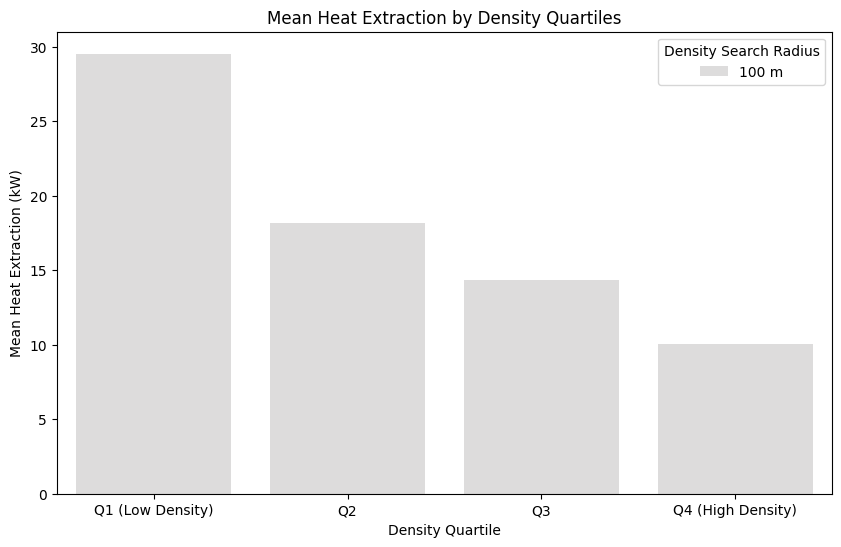

In [19]:
# Create a bar plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=quartile_comparison_df, 
    x="density_quartile", 
    y="Waermeentnahme", 
    hue="Density Measure", 
    palette="coolwarm"
)

# Titles and labels
plt.title("Mean Heat Extraction by Density Quartiles")
plt.xlabel("Density Quartile")
plt.ylabel("Mean Heat Extraction (kW)")
plt.legend(title="Density Search Radius")

# Show plot
plt.show()

The analysis provides **evidence** that **higher borehole density reduces individual heat extraction**, likely due to **thermal interference**. By dividing the dataset into **quartiles of borehole density** (`Q1` to `Q4`), we observed a **clear trend**:  

- **Low-density areas (Q1) exhibit the highest extraction rates (~26-30 kW)**.  
- **High-density areas (Q4) show significantly lower values (~8-11 kW)**.   

This **strongly suggests that closely spaced boreholes compete for the same underground heat**, reducing efficiency. The effect remains stable across different distance thresholds, reinforcing its reliability.

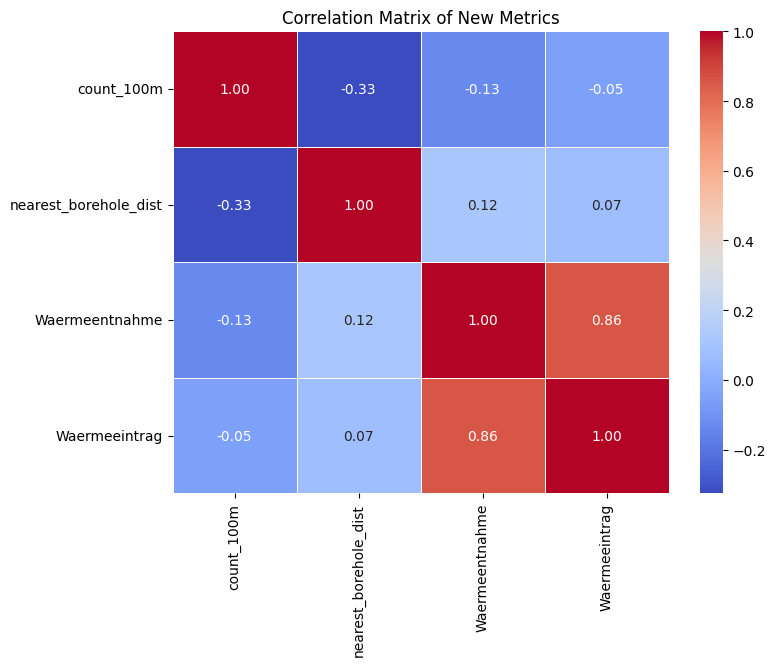

In [43]:
# Select relevant numerical columns for correlation
corr_columns = ["count_100m", "nearest_borehole_dist", "Waermeentnahme", "Waermeeintrag"]
corr_matrix = zh_geothermal_probes_gdf[corr_columns].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Titles and labels
plt.title("Correlation Matrix of New Metrics")
plt.show()

The borehole density metric (`count_100m`) exhibits a weak negative correlation (~ -0.13) with heat extraction (`Waermeentnahme`), and lower yet for heat contribution (`Waermeeintrag`), indicating that thermal interference may reduce efficiency in high-density areas, which is the expected outcome. Similarly, the distance to the nearest borehole (`nearest_borehole_dist`) shows a weak positive correlation (0.12), suggesting that boreholes farther apart might extract slightly more energy, though the effect is minimal.

The depth penalty (`depth_penalty`), designed to capture interference from closely spaced boreholes with similar depths, has almost no correlation (-0.05), implying that its current formulation may need refinement to better reflect its impact.  

Since the primary predictors of energy yield will come from **borehole depth, geographical location, and operational parameters**, these density-based metrics will serve as **adjustment factors** to account for interactivity between boreholes. Rather than being standalone predictors, they will be used as **interaction terms** with core features to help the model incorporate localized thermal depletion effects. To evaluate their usefulness, we will first train a baseline model with primary predictors, then introduce density-based features and assess their contribution to predictive performance.  

---

## 6. Normalization of new variables

In the next steps, we will refine the newly created key variables: **borehole density** (`count_100m`) and **proximity to the nearest borehole** (`nearest_borehole_dist`), which help account for the thermal interaction effects between boreholes, which in return can influence energy yield and heat recovery. To ensure consistency and improve model performance, we will normalize both variables using **min-max scaling**, transforming their values into a range between 0 and 1. This will help standardize their influence in predictive models while preserving the original distribution.

After normalization, we will analyze the data distribution using **boxplots** to assess the presence of extreme values.

In [62]:
zh_geothermal_probes_gdf.head()[["count_100m", "nearest_borehole_dist"]]

,count_100m,nearest_borehole_dist
0,6,42.580489
1,1,86.104299
2,7,11.402368
3,7,7.615773
4,7,7.615773


Firstly we check the distribution of the newly created variables to assess which normalization method is best.

In [63]:
# Normalize selected columns to range [0,1]
zh_geothermal_probes_gdf["count_100m_norm"] = zh_geothermal_probes_gdf["count_100m"] / zh_geothermal_probes_gdf["count_100m"].max()
zh_geothermal_probes_gdf["nearest_borehole_dist_norm"] = zh_geothermal_probes_gdf["nearest_borehole_dist"] / zh_geothermal_probes_gdf["nearest_borehole_dist"].max()

# Display updated dataframe
zh_geothermal_probes_gdf[["count_100m_norm", "nearest_borehole_dist_norm"]].head()

,count_100m_norm,nearest_borehole_dist_norm
0,0.098361,0.022562
1,0.016393,0.045623
2,0.114754,0.006042
3,0.114754,0.004035
4,0.114754,0.004035


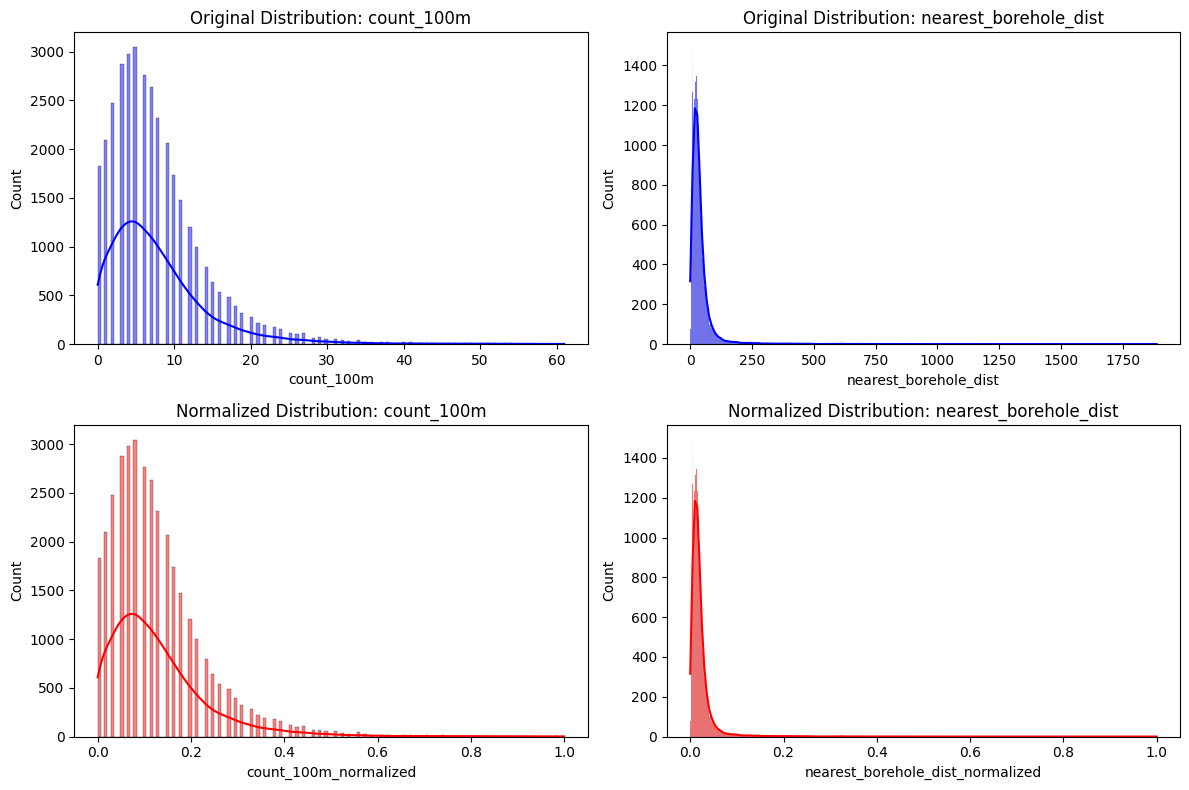

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the columns to normalize
columns_to_normalize = ["count_100m", "nearest_borehole_dist"]

# Create a figure
fig, axes = plt.subplots(2, len(columns_to_normalize), figsize=(12, 8))

# Loop through each variable
for i, col in enumerate(columns_to_normalize):
    # Plot original distribution
    sns.histplot(zh_geothermal_probes_gdf[col], kde=True, ax=axes[0, i], color="blue")
    axes[0, i].set_title(f"Original Distribution: {col}")
    
    # Normalize the column
    zh_geothermal_probes_gdf[f"{col}_normalized"] = zh_geothermal_probes_gdf[col] / zh_geothermal_probes_gdf[col].max()

    # Plot normalized distribution
    sns.histplot(zh_geothermal_probes_gdf[f"{col}_normalized"], kde=True, ax=axes[1, i], color="red")
    axes[1, i].set_title(f"Normalized Distribution: {col}")

plt.tight_layout()
plt.show()


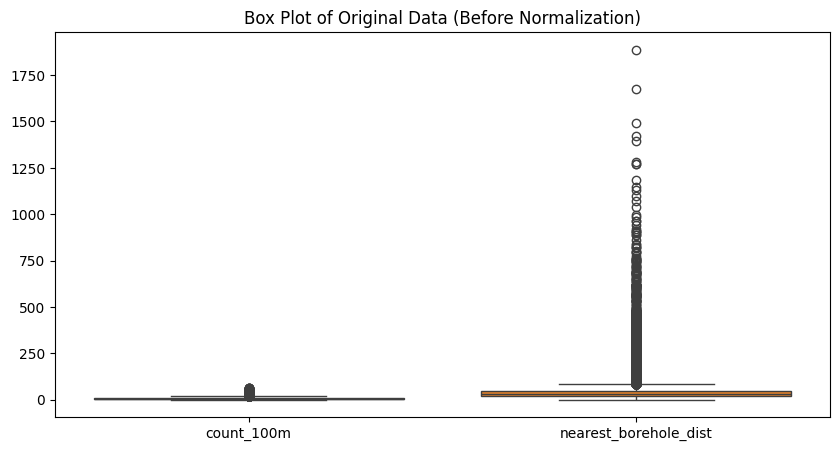

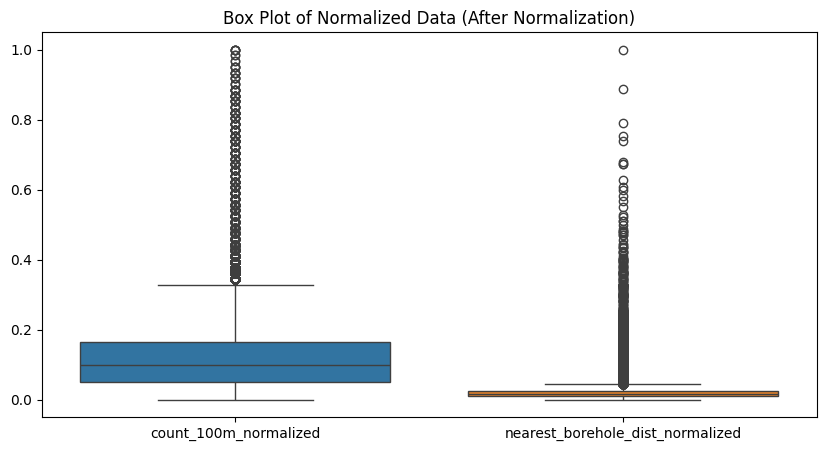

In [24]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=zh_geothermal_probes_gdf[["count_100m", "nearest_borehole_dist"]])
plt.title("Box Plot of Original Data (Before Normalization)")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=zh_geothermal_probes_gdf[["count_100m_normalized", "nearest_borehole_dist_normalized"]])
plt.title("Box Plot of Normalized Data (After Normalization)")
plt.show()

For now, the decision is to preserve the skewed structure, as it may carry important information for the prediction phase. The skewness in variables like borehole density and nearest borehole distance likely reflects real-world spatial clustering effects, which could influence thermal interactions and energy yield. If we apply transformations that overly standardize or symmetrize the data, we risk losing meaningful patterns that the model could leverage for accurate predictions.

---

## 7. Incorporating top elevation

As a last geographical assessment we consider the elevation above sea level in metres of the top of each point. To determine whether **top elevation** should be included as a predictive variable, we will assess its potential influence on geothermal energy yield. Elevation may capture **regional geological variations**, **thermal gradients**, or **hydrological factors** that affect heat extraction efficiency. Additionally, since borehole depth is measured relative to the surface, elevation could help refine the absolute positioning of boreholes in the subsurface. However, if elevation differences across the study area are minor, its predictive value might be limited.  

We will follow the **same assessment methodology** used for previous derived variables. This includes: (1) analyzing the **range and distribution** of elevation values, (2) performing an **OLS regression** to test its correlation with heat extraction (`Waermeentnahme`), and (3) **visualizing** the relationship between elevation and yield. If the results indicate a statistically significant impact, elevation will be retained in the model; otherwise, we will exclude it to maintain model efficiency.

The new data will be extracted similarly to the map widget's mechanism to obtain maximum allowed depths and elevations for given points, by leveraging the custom script created for that purpose.

In [46]:
import concurrent.futures
import time
from scripts.depth_query import get_depth_info  # Depth calculator

# Function to fetch elevation with progress updates
def fetch_elevation(index, coords, total):
    lat, lon = coords
    elevation, _ = get_depth_info(lat, lon)
    
    # Print progress every 500 boreholes
    if index % 500 == 0 or index == total - 1:
        print(f"Processed {index + 1}/{total} boreholes...")

    return elevation

# Prepare input data
total_boreholes = len(zh_geothermal_probes_gdf)
coords_list = list(zip(zh_geothermal_probes_gdf["lat"], zh_geothermal_probes_gdf["lon"]))

# Use ThreadPoolExecutor for parallel processing
start_time = time.time()
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    top_elevations = list(executor.map(lambda args: fetch_elevation(*args, total_boreholes), enumerate(coords_list)))

# Add results to DataFrame
zh_geothermal_probes_gdf["top_elevation"] = top_elevations

# Completion message
print(f"✅ Elevation retrieval completed in {time.time() - start_time:.2f} seconds.")

output_path = "data/transformed/zh_geothermal_probes_with_density_elevation.geojson"
zh_geothermal_probes_gdf.to_file(output_path, driver="GeoJSON")

# Display updated DataFrame
zh_geothermal_probes_gdf.head()

Processed 1/35667 boreholes...
Processed 501/35667 boreholes...
Processed 1001/35667 boreholes...
Processed 1501/35667 boreholes...
Processed 2001/35667 boreholes...
Processed 2501/35667 boreholes...
Processed 3001/35667 boreholes...
Processed 3501/35667 boreholes...
Processed 4001/35667 boreholes...
Processed 4501/35667 boreholes...
Processed 5001/35667 boreholes...
Processed 5501/35667 boreholes...
Processed 6001/35667 boreholes...
Processed 6501/35667 boreholes...
Processed 7001/35667 boreholes...
Processed 7501/35667 boreholes...
Processed 8001/35667 boreholes...
Processed 8501/35667 boreholes...
Processed 9001/35667 boreholes...
Processed 9501/35667 boreholes...
Processed 10001/35667 boreholes...
Processed 10501/35667 boreholes...
Processed 11001/35667 boreholes...
Processed 11501/35667 boreholes...
Processed 12001/35667 boreholes...
Processed 12501/35667 boreholes...
Processed 13001/35667 boreholes...
Processed 13501/35667 boreholes...
Processed 14001/35667 boreholes...
Processed

,gml_id,Waermeentnahme,Waermeeintrag,Sondentiefe,Gesamtsondenzahl,GBS-Nummer,Bohrprofil,lon,lat,count_100m,nearest_borehole_dist,geometry,top_elevation
0,erdwaermesonden.1464734,20.4,0.0,250,3.0,b 00-10370,0,8.561441,47.380481,6,42.580489,POINT (2684788.902 1248344.823),565.4
1,erdwaermesonden.1464735,68.0,0.0,250,10.0,b 00-10371,1,8.563721,47.379955,1,86.104299,POINT (2684961.902 1248288.82),569.3
2,erdwaermesonden.1464736,12.5,6.0,250,2.0,b 00-10287,0,8.559411,47.382209,7,11.402368,POINT (2684632.902 1248534.826),567.9
3,erdwaermesonden.1464737,12.5,6.0,250,2.0,b 00-10288,0,8.559317,47.382129,7,7.615773,POINT (2684625.901 1248525.826),566.0
4,erdwaermesonden.1464738,12.5,6.0,250,2.0,b 00-10289,0,8.559276,47.382067,7,7.615773,POINT (2684622.901 1248518.826),564.5


In [64]:
# Compute bottom elevation
zh_geothermal_probes_gdf["bottom_elevation"] = zh_geothermal_probes_gdf["top_elevation"] - zh_geothermal_probes_gdf["Sondentiefe"]

# Display updated dataframe
zh_geothermal_probes_gdf[["top_elevation", "Sondentiefe", "bottom_elevation"]].head()

KeyError: 'top_elevation'

In [65]:
# Select relevant numerical columns for correlation
corr_columns = ["count_100m", "nearest_borehole_dist", "top_elevation", "Sondentiefe", "bottom_elevation", "Waermeentnahme", "Waermeeintrag"]
corr_matrix = zh_geothermal_probes_gdf[corr_columns].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Titles and labels
plt.title("Correlation Matrix of New Metrics")
plt.show()

KeyError: "['top_elevation'] not in index"

In [58]:
# Define independent variables
depth_metrics = ["Sondentiefe", "bottom_elevation"]

# Store results
regression_results = {}

for metric in depth_metrics:
    X = zh_geothermal_probes_gdf[[metric]]  # Select one variable at a time
    X = sm.add_constant(X)  # Add constant term for intercept
    y = zh_geothermal_probes_gdf["Waermeentnahme"]  # Target variable

    # Train regression model
    model = sm.OLS(y, X).fit()

    # Store R² and p-value
    regression_results[metric] = {
        "R² Score": model.rsquared,
        "p-value": model.pvalues[metric]
    }

# Convert results to a DataFrame
regression_summary = pd.DataFrame(regression_results).T

# Display results
regression_summary

,R² Score,p-value
Sondentiefe,0.033545,1.291964e-266
bottom_elevation,0.024953,5.307575e-198


In [59]:
# Define independent variables
depth_metrics = ["Sondentiefe", "bottom_elevation"]

# Store results
regression_results = {}

for metric in depth_metrics:
    X = zh_geothermal_probes_gdf[[metric]]  # Select one variable at a time
    X = sm.add_constant(X)  # Add constant term for intercept
    y = zh_geothermal_probes_gdf["Waermeeintrag"]  # Target variable

    # Train regression model
    model = sm.OLS(y, X).fit()

    # Store R² and p-value
    regression_results[metric] = {
        "R² Score": model.rsquared,
        "p-value": model.pvalues[metric]
    }

# Convert results to a DataFrame
regression_summary = pd.DataFrame(regression_results).T

# Display results
regression_summary

,R² Score,p-value
Sondentiefe,0.001923,1.181737e-16
bottom_elevation,0.002469,6.001857e-21


In [67]:
# Drop top_elevation from the dataset
zh_geothermal_probes_gdf = zh_geothermal_probes_gdf.drop(columns=["top_elevation"])
zh_geothermal_probes_gdf.head()

,gml_id,Waermeentnahme,Waermeeintrag,Sondentiefe,Gesamtsondenzahl,GBS-Nummer,Bohrprofil,lon,lat,count_100m,nearest_borehole_dist,geometry,bottom_elevation,count_100m_norm,nearest_borehole_dist_norm
0,erdwaermesonden.1464734,20.4,0.0,250,3.0,b 00-10370,0,8.561441,47.380481,6,42.580489,POINT (2684788.902 1248344.823),315.4,0.098361,0.022562
1,erdwaermesonden.1464735,68.0,0.0,250,10.0,b 00-10371,1,8.563721,47.379955,1,86.104299,POINT (2684961.902 1248288.82),319.3,0.016393,0.045623
2,erdwaermesonden.1464736,12.5,6.0,250,2.0,b 00-10287,0,8.559411,47.382209,7,11.402368,POINT (2684632.902 1248534.826),317.9,0.114754,0.006042
3,erdwaermesonden.1464737,12.5,6.0,250,2.0,b 00-10288,0,8.559317,47.382129,7,7.615773,POINT (2684625.901 1248525.826),316.0,0.114754,0.004035
4,erdwaermesonden.1464738,12.5,6.0,250,2.0,b 00-10289,0,8.559276,47.382067,7,7.615773,POINT (2684622.901 1248518.826),314.5,0.114754,0.004035


In [68]:
output_path = "data/transformed/zh_geothermal_probes_with_density_elevation.geojson"
zh_geothermal_probes_gdf.to_file(output_path, driver="GeoJSON")